Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Quick Start: Running AlphaFold2 on AWS Batch

## Table of Contents
0. [Install Dependencies](#0.-Install-Dependencies)
1. [Create Target](#1.-Create-Target)
2. [Submit Sequence Alignment and Folding Jobs](#2.-Submit-Sequence-Alignment-and-Folding-Jobs) 
3. [Download results](#3.-Download-results)
4. [Visualze results](#4.-Visualize-results)

## 0. Install Dependencies

In [1]:
# Import required Python packages

import boto3
from datetime import datetime
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.alphafold2_job import AlphaFold2Job
from batchfold.batchfold_target import BatchFoldTarget
from batchfold.jackhmmer_job import JackhmmerJob
import matplotlib.pyplot as plt
from nbhelpers import nbhelpers

# Create AWS clients
boto_session = boto3.session.Session()
batch_environment = BatchFoldEnvironment(boto_session = boto_session)

S3_BUCKET = batch_environment.default_bucket
print(f" S3 bucket name is {S3_BUCKET}")

 S3 bucket name is batch-protein-folding-220802-co-batchfolds3bucket-s40zpnlg8lj1


## 1. Create Target

In [2]:
target_id = "7VNA"
target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET)
target.add_sequence(
    seq_id=target_id,
    seq="GSIPHKENMFKSKHKLDFSLVSMDQRGKHILGYADAELVNMGGYDLVHYDDLAYVASAHQELLKTGASGMIAYRYQKKDGEWQWLQTSSRLVYKNSKPDFVICTHRQLMDEEGHDLLGKR",
    description="Chain A|Ahr homolog spineless|Drosophila melanogaster",
)

's3://batch-protein-folding-220802-co-batchfolds3bucket-s40zpnlg8lj1/7VNA/fastas/7VNA.fasta'

## 2. Submit Sequence Alignment and Folding Jobs

In [3]:
jackhmmer_job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
jackhmmer_job = JackhmmerJob(
        job_name = jackhmmer_job_name,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        output_s3_uri = target.get_msas_s3_uri(),
        boto_session = boto_session,
        cpu = 16,
        memory = 32
    )

alphafold2_job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
alphafold2_job = AlphaFold2Job(
    job_name = alphafold2_job_name,
    boto_session = boto_session,
    target_id = target.target_id,
    fasta_s3_uri = target.get_fasta_s3_uri(),
    msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer",
    output_s3_uri = target.get_predictions_s3_uri() + "/" + alphafold2_job_name,
    use_precomputed_msas = True,
    model_preset = "monomer_ptm",    
    benchmark = True,
    cpu = 4,
    memory = 15, # Why not 16? ECS needs about 1 GB for container services
    gpu = 1
)

jackhmmer_submission = batch_environment.submit_job(jackhmmer_job, job_queue_name="GravitonSpotJobQueue")
alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])

Check on job statuses

In [5]:
for job in [jackhmmer_job, alphafold2_job]:
    print(f"Job {job.describe_job()[0]['jobName']} is in status {job.describe_job()[0]['status']}")

Job 7VNA_JackhmmerJob_202208041659625986 is in status SUCCEEDED
Job 7VNA_AlphaFold2Job_202208041659625986 is in status SUCCEEDED


## 3. Download Results

Once the jobs are finished, download the results

In [6]:
target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
target.download_all(local_path="data")

1 files downloaded from s3.
6 files downloaded from s3.
5 files downloaded from s3.
0 files downloaded from s3.
23 files downloaded from s3.
3 files downloaded from s3.
3 files downloaded from s3.
3 files downloaded from s3.
0 files downloaded from s3.
0 files downloaded from s3.
0 files downloaded from s3.


'/Users/bloyal/batch-protein-folding/notebooks/data'

## 4. Visualize Results

### Plot Alignment Data

6145 Sequences Found in uniref90
483 Sequences Found in mgnify

6608 Sequences Found in Total



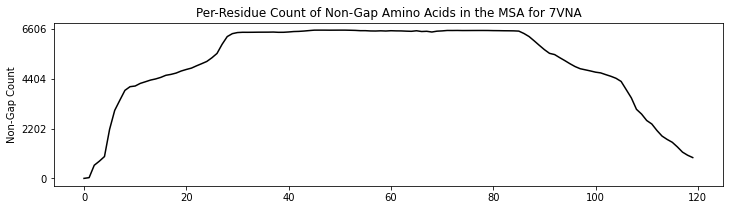

In [7]:
plt = nbhelpers.msa_plot(target_id, f"data/{target_id}/msas/jackhmmer")
plt.show()

### Plot Predicted Structure

In [8]:
last_job_name = target.list_job_names(job_type="AlphaFold2")[0]
nbhelpers.pdb_plot(pdb_path = f"data/{target_id}/predictions/{last_job_name}", show_sidechains=False).show()

KeyError: 'predicted_aligned_error'

In [9]:
import tmscoring
import py3Dmol

last_alphafold_job_name = target.list_job_names(job_type="AlphaFold")[0]

alphafold_alignment = tmscoring.TMscoring(
    f"data/{target.target_id}/predictions/{last_alphafold_job_name}/ranked_0.pdb",
    f"data/pdb/{target.target_id}.pdb"
    )

# Find the optimal alignment
alphafold_alignment.optimise()

# Get the TM score:
tm_score = alphafold_alignment.tmscore(**alphafold_alignment.get_current_values())
print(f"TM score is {tm_score}")

# Save the aligned files:
alphafold_alignment.write(outputfile='alphafold_alignment.pdb', appended=True)

with open("alphafold_alignment.pdb") as f:
    aligned_pdb = f.read()

view = py3Dmol.view(width=800, height=600)
view.addModels(aligned_pdb)

for n, chain, color in zip(range(2), ["A","B","C",], ["red", "blue", "green"]):
    view.setStyle({"chain": chain}, {"cartoon": {"color": color}}).zoomTo()
view.show()


ValueError: need at least one array to concatenate

In [10]:
import numpy as np
import os
def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o